# Installation
If you already have the python package pyfftw installed, you should not need to install ultrafastultrafast in order to run this notebook.  If you do want to install the code, see README for instructions (installing ultrafastultrafast should also install pyfftw).

In [1]:
%matplotlib notebook
import ultrafastultrafast as uf2
import numpy as np
import matplotlib.pyplot as plt

# $\text{UF}^2$
This code is based upon the algorithm Ultrafast Ultrafast ($\text{UF}^2$).  For details see our paper https://doi.org/10.1063/1.5094062.

The fundamental building block of this code is the class uf2.Wavepackets, which implements the $K_j$ and $K_{j^*}$ operators, which are class methods named "up" and "down" respectively, and can be used to calculate the wavepackets associated with any Feynman diagram.  See section Example Diagram below for an example of calculating a single diagram.  See section Signals below for examples of calculating full nonlinear optical signals.

## Requirements 
$\text{UF}^2$ is a method for solving for the perturbative wavepackets of the full Hamiltonian
$$H = H_0 -\boldsymbol{\mu}\cdot \boldsymbol{E}(t)$$
using time-dependent perturbation theory (TDPT). Bold-face symbols are cartesian vectors.  $\text{UF}^2$ requires that the system Hamiltonian, $H_0$ be time-independent, and therefore diagonalizeable.  The eigenvalues, $\hbar\omega_i$ of $H_0$ must be known
$$H_0|i\rangle = \hbar\omega_i|i\rangle.$$
The dipole operator $\boldsymbol{\mu}$ must also be known in the eigenbasis of $H_0$:
$$\boldsymbol{\mu}_{ij} = \langle j|\boldsymbol{\mu}|i\rangle$$

In order to use this code, you must specify the file_path variable to a folder you create

In [2]:
file_path = 'example_folder/' #Example included with this code

The folder must contain two numpy archive files: 
- eigenvalues.npz - containing up to three keys, each referencing a 1d numpy array
    - 'GSM' - Array of ground state manifold eigenvalues
    - 'SEM' - Array of singly excited manifold eigenvalues
    - 'DEM' (optional) - Array of doubly excited manifold eigenvalues
- mu.npz - containing up to two keys, each referencing a 3d numpy array
    - 'GSM_to_SEM' - Array with indices [i,j,k], representing the dipole operator connecting ground eigenstates (index j) to singly excited eigenstates (index i), with the cartesian coordinate k = 0,1,2 corresponding to k = x,y,z
    - 'SEM_to_DEM' - Array with indices [i,j,k], representing the dipole operator connecting singly excited eigenstates (index j) to doubly excited eigenstates (index i), with the cartesian coordinate k = 0,1,2 corresponding to k = x,y,z
    
The example folder included contains these files:

In [3]:
eigenvalues_archive = np.load(file_path + 'eigenvalues.npz')
GSM_eigenvalues = eigenvalues_archive['GSM']
SEM_eigenvalues = eigenvalues_archive['SEM']
print('Number of GSM eigenvalues',GSM_eigenvalues.shape)
print('Number of SEM eigenvalues',SEM_eigenvalues.shape)

mu_archive = np.load(file_path + 'mu.npz')
mu_GSM_to_SEM = mu_archive['GSM_to_SEM']
print('Shape of dipole operator connecting GSM to SEM',mu_GSM_to_SEM.shape)

Number of GSM eigenvalues (40,)
Number of SEM eigenvalues (40,)
Shape of dipole operator connecting GSM to SEM (40, 40, 3)


### Dipole Pruning (optional)
You may choose to prune or trim the dipole operator contained in mu.npz down to the fewest necessary states.  This is done by specifying a relative tolerance to use when resolving the dipole operator.  The pruning is implemented as

In [4]:
epsilon_mu = 1E-3
dp = uf2.DipolePruning(file_path)
dp.save_boolean_mu(rel_tol = epsilon_mu)

There should now be two new files in example_folder: mu_pruned.npz and mu_boolean.npz.  mu_pruned.npz is essentially a copy of mu.npz, but with 0's placed in any entries that do not contribute to the given tolerance.  mu_boolean.npz is a boolean array with 2 indices [i,j] that has True for any unaffected values $\mu_{ij}$, and False where ever the pruning process set $\mu_{ij}=0$.

## Example Diagram
Here is an example of how to use the algorithm to calculate the SE contribution of a pump-probe experiment.  We begin by specifying the relevant electric fields. Note that $\text{UF}^2$ does not require analytical pulse shapes.  We use Gaussian pulses here as an example.

In [5]:
def pump(t,sigma):
    """Define pump field"""
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-t**2/(2*sigma**2))

def probe(t,sigma):
    """Define the probe field"""
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-t**2/(2*sigma**2))

In [6]:
dt = 0.1 # in units of omega_0^-1, time spacing required to resolve all pulse shapes
M = 138 # in units of omega_0^-1, number of points required to resolve all pulse shapes

## Units
Units enter UF2 implicitly via the eigenvalues of the system hamiltonian.  We assume that the eigenvalues are expressed as multiples of some angular frequency $\omega_0$.  All times are expressed in units of $\omega_0^{-1}$, and all frequencies are expressed in units of $\omega_0$.

In [7]:
psi0_state = 0 # Index of initial ground state manifold eigenstate that the system begins in

total_t = int(200/dt) # in units of omega_0^-1, total number of time points - 
                      # must span from 0 to 5/gamma beyond last delay time point

wp = uf2.Wavepackets(file_path,dt=dt,num_conv_points=M,initial_state=psi0_state,total_num_time_points=total_t)

# Define the pump and probe amplitude functions.  Note that both should be defined centered at t = 0

pump_sigma = 0.8 # in units of omega_0^-1
probe_sigma = 1 # in units of omega_0^-1

# The value of M and dt specified create an array of time points that must be used to evaluate the electric field
# That array is stored inside of the Wavepackets object with attribute efield_t

# pu and pr do not need to be evaluated using an analytical pulse function
pu = pump(wp.efield_t,pump_sigma) # Could be a numpy array of M points describing an arbitrary pulse shape
pr = probe(wp.efield_t,probe_sigma) # Could be a numpy array of M points describing an arbitrary pulse shape

# Pump-probe spectroscopy is calculated to lowest order as four-wave mixing
# where the pump provides the first two interactions, and the probe
# provides the third interaction, and acts as the "fourth interaction" in 
# the form of the local oscillator

wp.efields = [pu,pu,pr,pr]

# The pump is polarized along the 'x' direcetion
# The probe is polarized along the same direction

wp.set_polarization_sequence(['x','x','x','x'])

# Set gamma - effective optical dephasing rate
wp.set_homogeneous_linewidth(0.05)

<IPython.core.display.Javascript object>


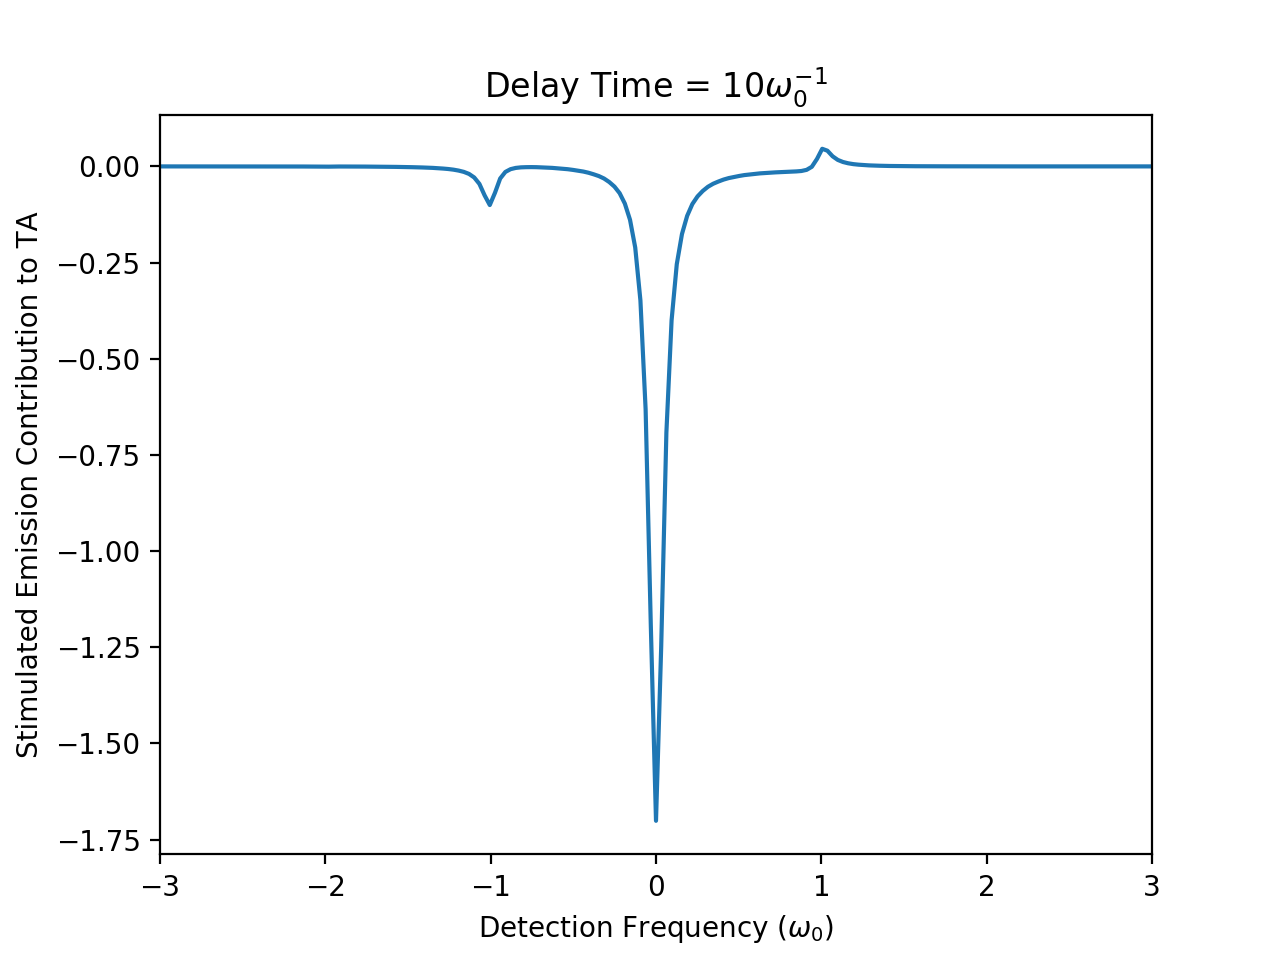

Text(0.5,1,'Delay Time = 10$\\omega_0^{-1}$')

In [8]:
# Create the wavepackets needed for the SE signal at the specified delay time

delay_time = 10

# Using this delay time, set the interaction times for each of the four interactions
# in the form [pump_time, pump_time, probe_time, probe_time]

wp.pulse_times = [0,0,delay_time,delay_time]

# Construct Perturbative Wavepackets

psi_b = wp.up(wp.psi0,pulse_number = 1)
psi_a = wp.up(wp.psi0,pulse_number = 0)
psi_ac = wp.down(psi_a,pulse_number = 2)

# Calculate the SE contribution to the resulting frequency-resolved spectrum at the specified delay time

# The time-dependent polarization field is the expectation value of the perturbed wavepackets and
# the dipole operator

SE_polarization = wp.dipole_expectation(psi_ac,psi_b)

# Finally convert that polarization into a heterodyne-detected signal

SE_signal = wp.polarization_to_signal(SE_polarization)

# The frequency-detected signal for this value of delay time is plotted here

plt.figure()
plt.plot(wp.w,SE_signal)
plt.xlim([-3,3])
plt.xlabel('Detection Frequency ($\omega_0$)')
plt.ylabel('Stimulated Emission Contribution to TA')
plt.title('Delay Time = {}'.format(delay_time) + '$\omega_0^{-1}$')

## Signals
There are four files located in the signals sub-directory that show examples of how to use uf2 to implement various $n$-wave mixing signals

### Transient Absorption

The file TA_example.py includes a class, TransientAbsorption, that calculates all of the required diagrams for the transient absorption signal using uf2.Wavepackets.  An example of using that class is given here.  To see how all of the diagrams are coded and combined into one signal, please see the code.

In [9]:
pump_sigma = 0.2
probe_sigma = 0.2
dt = min(pump_sigma,probe_sigma)/2
M = 138
total_t = int(200/dt)

<IPython.core.display.Javascript object>


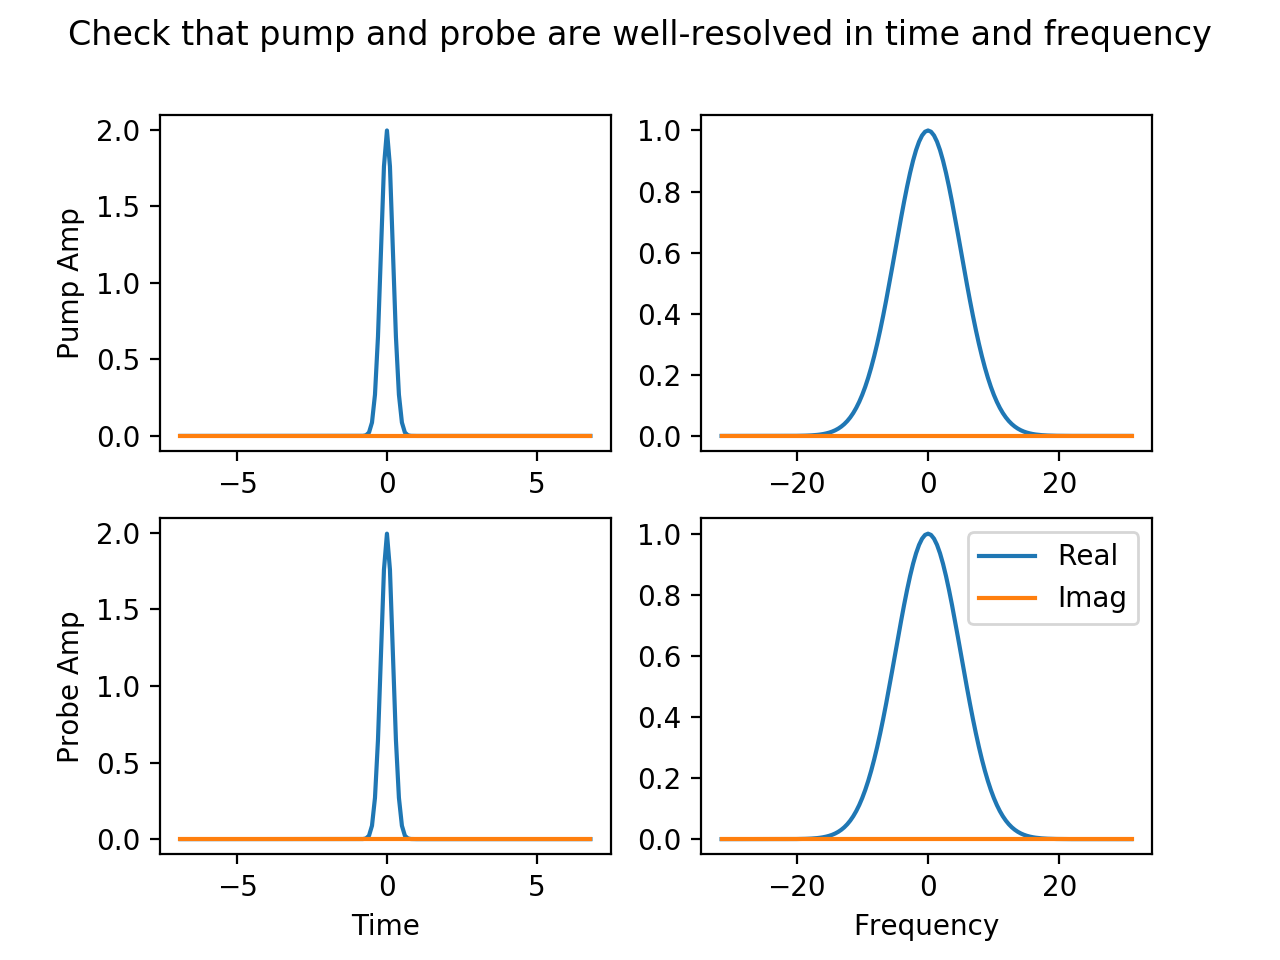

In [10]:
# Initialize object with filepath to saved eigenvalues and dipole operator
ta = uf2.signals.TransientAbsorption(file_path,dt=dt,num_conv_points=M,total_num_time_points=total_t)

# As before, signal fields and polarization sequence must be set

pu = pump(ta.efield_t,pump_sigma) #Using above Gaussian field definition
pr = probe(ta.efield_t,probe_sigma) #Using above Gaussian field definition

# The class TransientAbsorption has a method for setting the four interaction fields given the pump shape and the
# probe shape

ta.set_pulse_shapes(pu,pr)

# The pump is polarized along the 'x' direcetion
# The probe is polarized along the same direcetion

pol_seq = ['x','x','x','x']

ta.set_polarization_sequence(pol_seq)

<IPython.core.display.Javascript object>


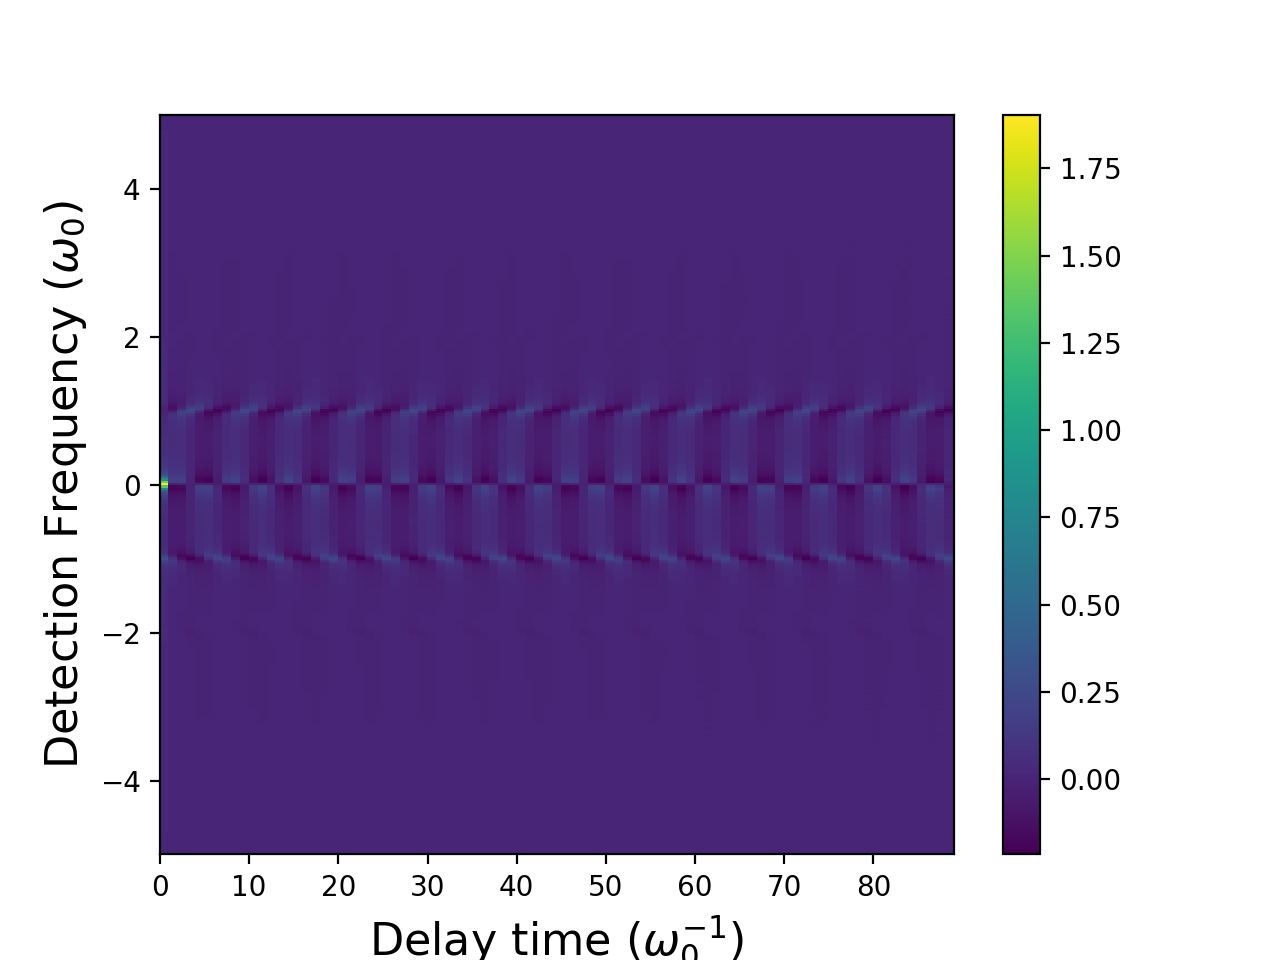

In [11]:
# Pick delay times of interest.  The code is written in such a way that negative delay times cannot be calculated. 
# This is a limitation of the implementation, not of the method
delay_times = np.arange(0,90,1) #delay times must coincide with time mesh calculation is performed on

# The class TransientAbsorption includes all necessary diagrams for calculating the TA signal

spectra = ta.calculate_pump_probe_spectra_vs_delay_time(delay_times)
ta.save_pump_probe_spectra_vs_delay_time()
ta.plot_pump_probe_spectra(frequency_range = [-5,5],subtract_DC=True,save_fig=True)

#### Isotropic Averaging

TA_isotorpic_average_example.py shows an example of how to isotropically average the transient absorption signal.  Here is an example implementing the class defined in that file

<IPython.core.display.Javascript object>


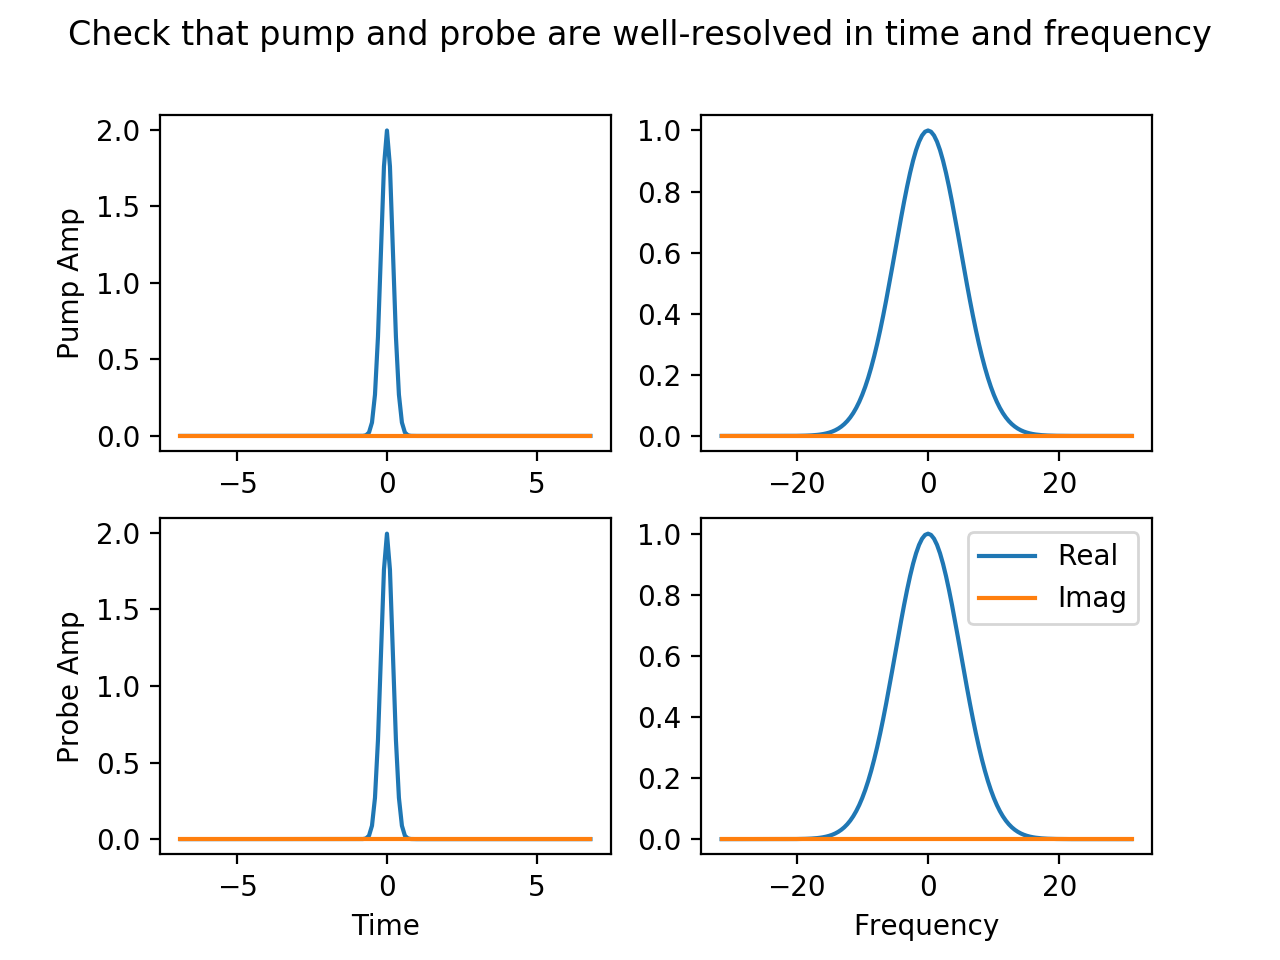

In [12]:
ta_iso = uf2.signals.TransientAbsorptionIsotropicAverage(file_path,pol_seq,dt=dt)
ta_iso.set_pulse_shapes(pu,pr)

<IPython.core.display.Javascript object>


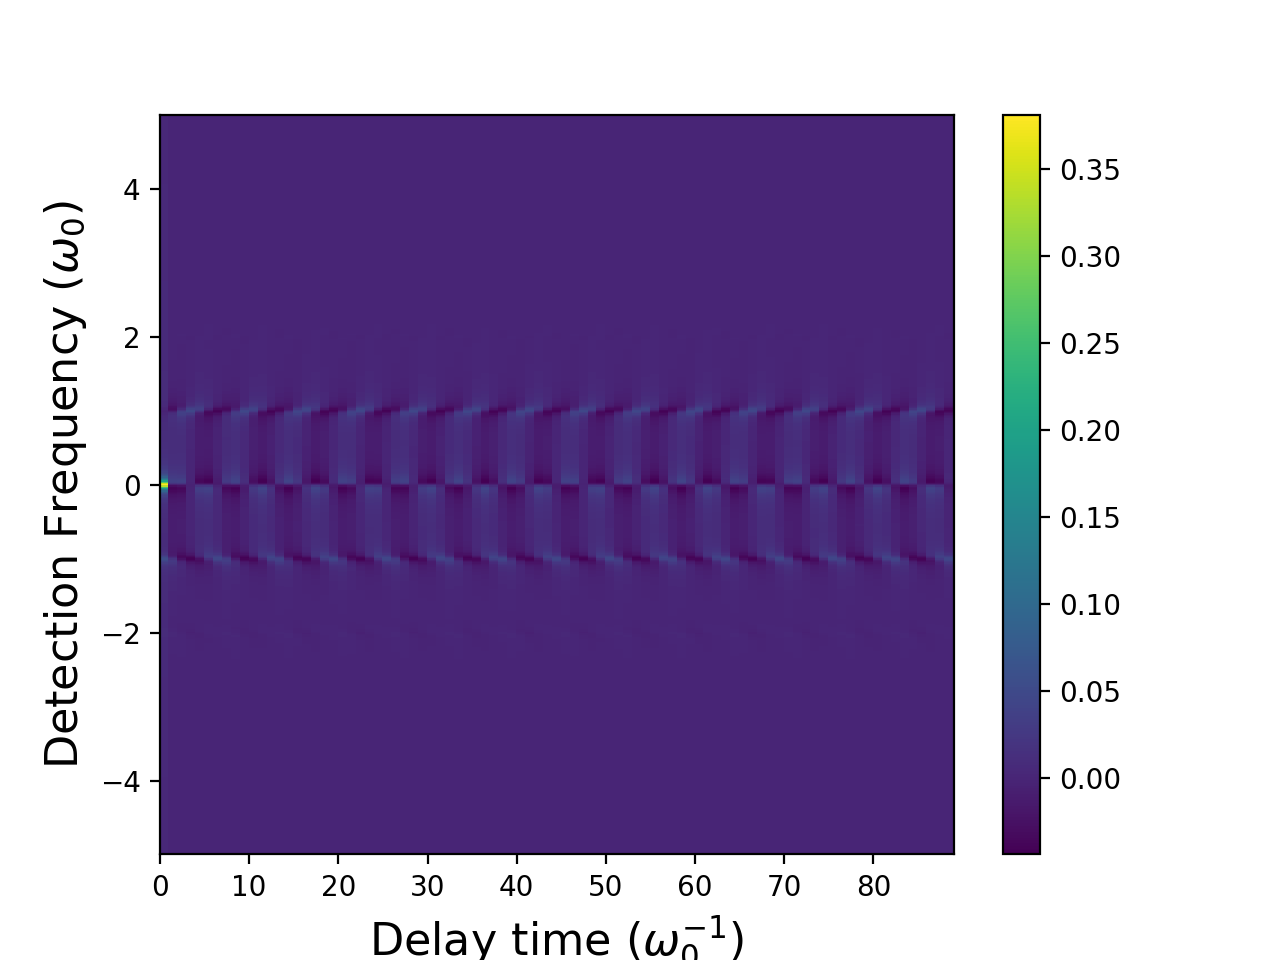

In [13]:
spectra_iso = ta_iso.calculate_spectra(delay_times)
ta_iso.save_pump_probe_spectra_vs_delay_time()
ta_iso.plot_pump_probe_spectra(frequency_range = [-5,5],subtract_DC=True,save_fig=True)

### 5th order contribution to transient absorption
The rest of this notebook gives an example of higher order perturbations. This is done to provide an example of how to calculate n-wave mixing. The signals calculated below are one of two 5th-order contributions that can contribute to the transient absorption. The one calculated below is the signal proportional to $\varepsilon_{pump}^4\varepsilon_{probe}^2$.  The other possible 5th-order contribution would be proportional to $\varepsilon_{pump}^2\varepsilon_{probe}^4$, but is not included here.

See the file TA_5th_order_example.py to see how this is implemented.

<IPython.core.display.Javascript object>


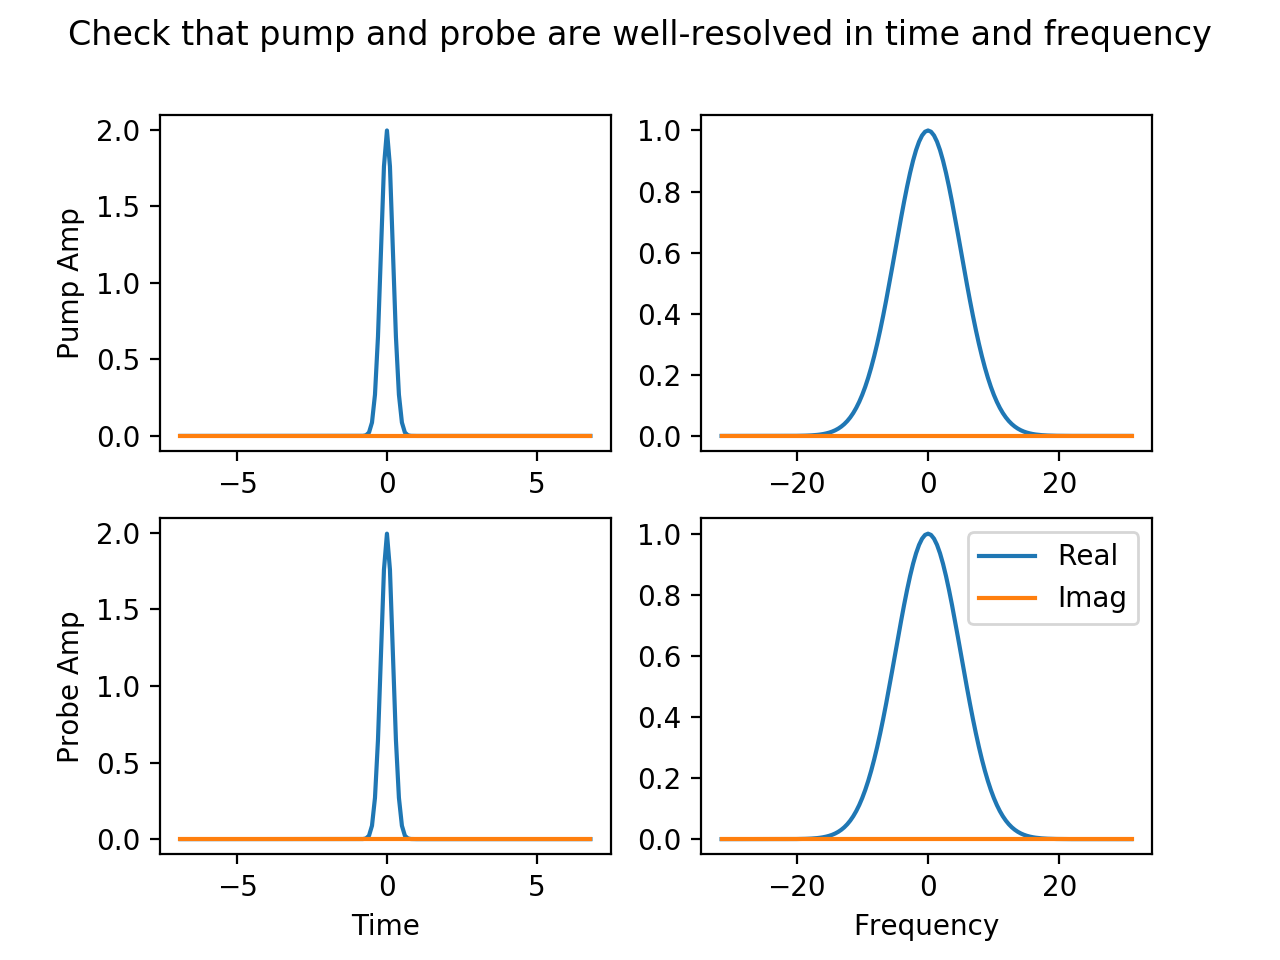

In [14]:
# Initialize object with filepath to saved eigenvalues and dipole operator

ta5th = uf2.signals.TransientAbsorption5thOrder(file_path,dt=dt,initial_state=psi0_state,num_conv_points=M,
                                                total_num_time_points=total_t)

# As before, signal fields and polarization sequence must be set

pu = pump(ta5th.efield_t,pump_sigma) #Using above Gaussian field definition
pr = probe(ta5th.efield_t,probe_sigma) #Using above Gaussian field definition

# The class TransientAbsorption has a method for setting the four interaction fields given the pump shape and the
# probe shape

ta5th.set_pulse_shapes(pu,pr)

# The pump is polarized along the 'x' direcetion
# The probe is polarized along the same direcetion

ta5th.set_polarization_sequence(['x','x','x','x','x','x'])

<IPython.core.display.Javascript object>


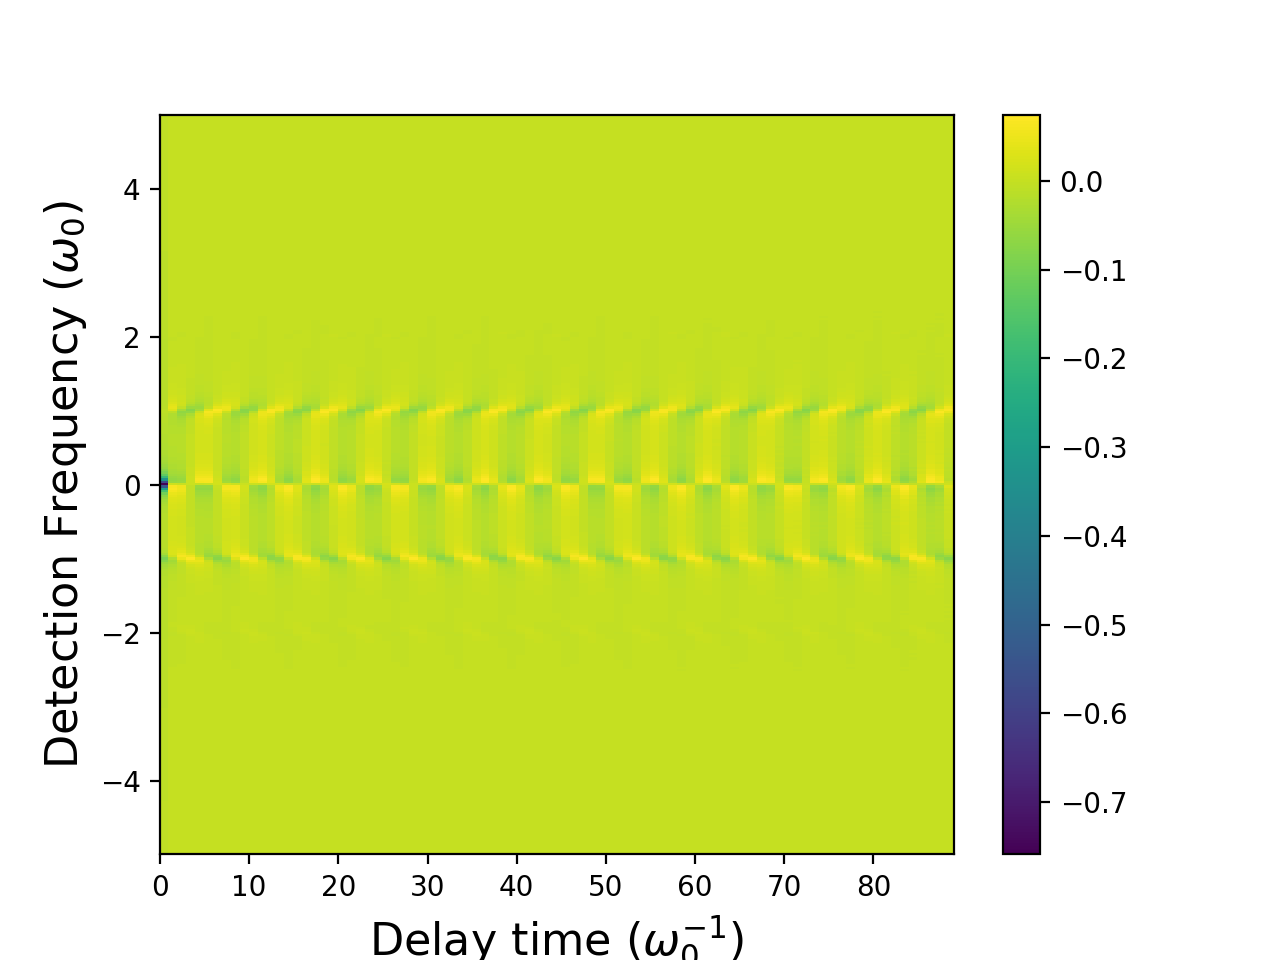

In [15]:
spectra5th = ta5th.calculate_pump_probe_spectra_vs_delay_time(delay_times)
ta5th.save_pump_probe_spectra_vs_delay_time()
ta5th.plot_pump_probe_spectra(frequency_range = [-5,5],subtract_DC=True)

#### Isotropic Averaging

See TA_5th_order_isotropic_average_example.py for details on how this is implemented.

<IPython.core.display.Javascript object>


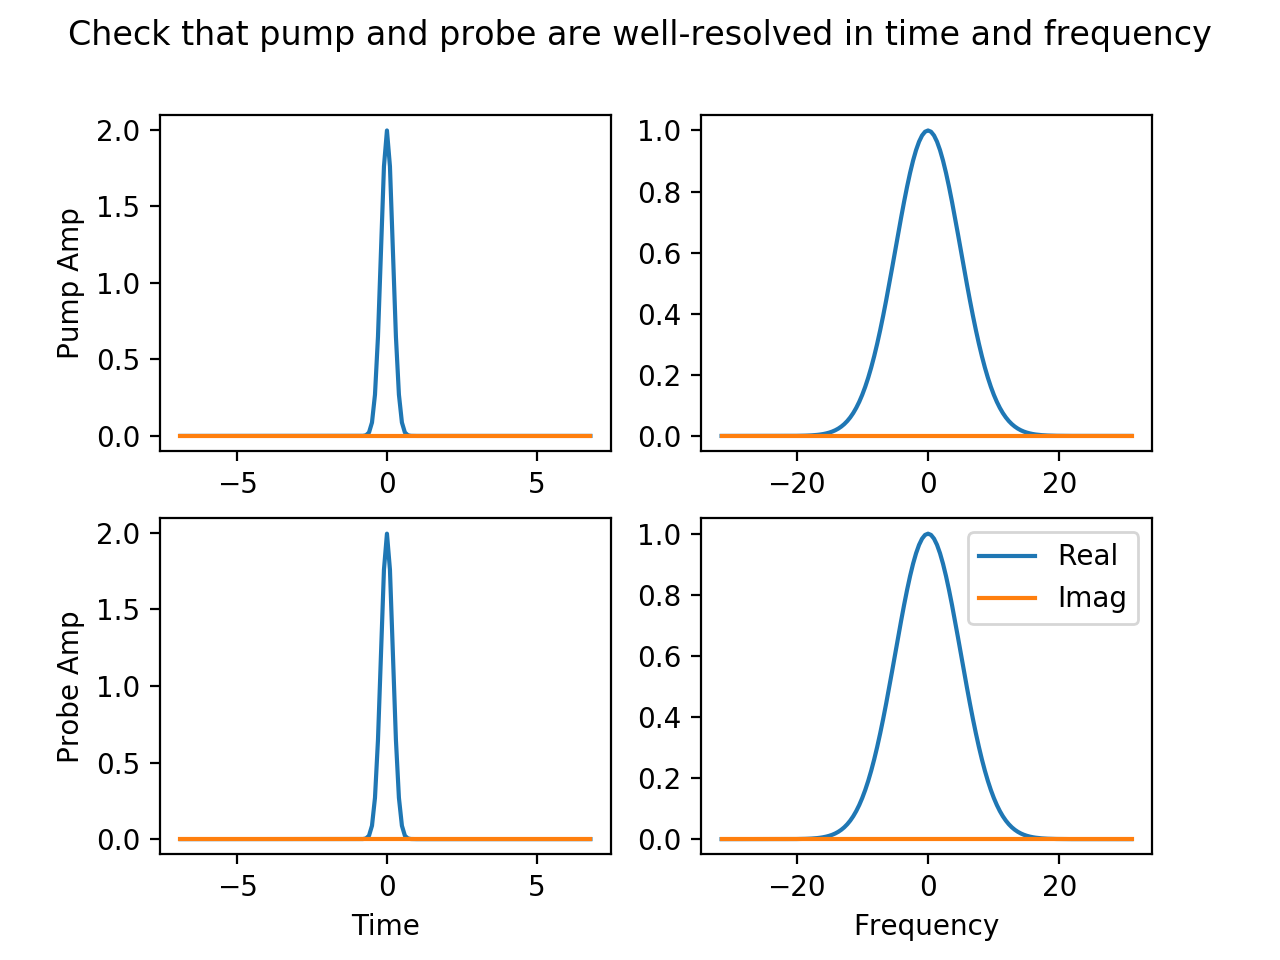

In [16]:
# Initialize object with filepath to saved eigenvalues and dipole operator

ta5th_iso = uf2.signals.TransientAbsorption5thOrderIsotropicAverage(file_path,['x','x','x','x','x','x'],dt=dt,
                                                                    initial_state=psi0_state,num_conv_points=M,
                                                                    total_num_time_points=total_t)

# As before, signal fields and polarization sequence must be set

pu = pump(ta5th_iso.TA.efield_t,pump_sigma) #Using above Gaussian field definition
pr = probe(ta5th_iso.TA.efield_t,probe_sigma) #Using above Gaussian field definition

# The class TransientAbsorption has a method for setting the four interaction fields given the pump shape and the
# probe shape

ta5th_iso.set_pulse_shapes(pu,pr)

<IPython.core.display.Javascript object>


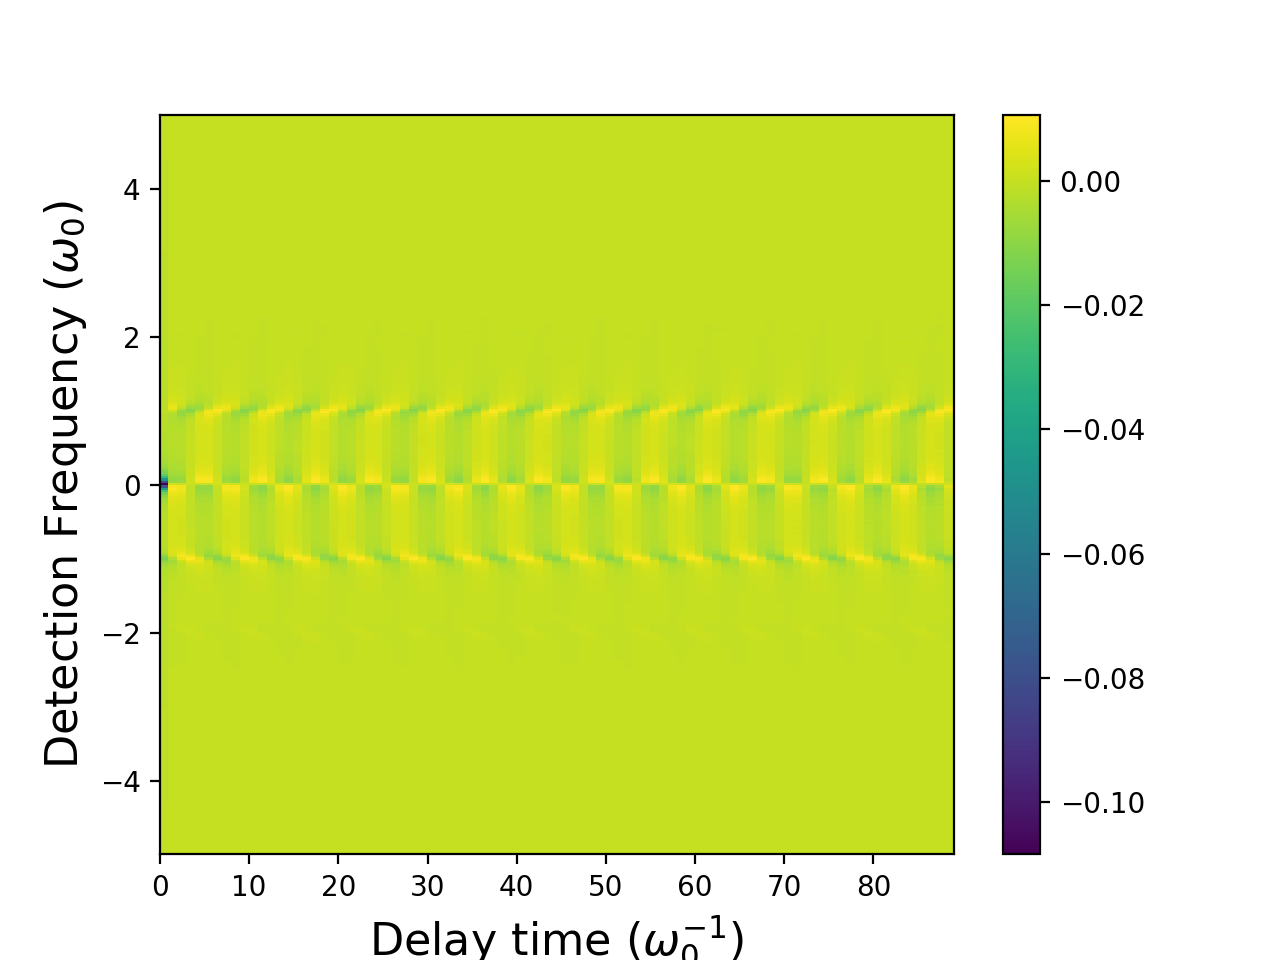

In [17]:
spectra5th_iso = ta5th_iso.calculate_spectra(delay_times)
ta5th_iso.save_pump_probe_spectra_vs_delay_time()
ta5th_iso.plot_pump_probe_spectra(frequency_range = [-5,5],subtract_DC=True)